# iModulon weight visualization

Load Eco_CIP_M_50 gene weights, map BW25113 loci to MG1655, compute Otsu thresholds (with quantile pre-filter) like MultiModulon, and plot `Component_14` with COG coloring from the MG gene table.

In [1]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Expose the local MultiModulon package (no install needed)
sys.path.append("/home/gaoyuan/PhD/iMM_2/multimodulon")
from multimodulon.species_data import SpeciesData
from multimodulon.plotting import view_iModulon_weights

In [2]:
data_dir = Path("Data")
m_path = data_dir / "Eco_CIP_M_50.csv"
gene_table_path = data_dir / "MG1655_gene_table.csv"
bbh_path = data_dir / "BW25113_MG1655_BBH.tsv"

# Load inputs
M_bw = pd.read_csv(m_path, index_col=0)
gene_table = pd.read_csv(gene_table_path, index_col=0)
bbh = pd.read_csv(bbh_path, sep="\t")

# Ensure numeric coordinates for plotting
gene_table["start"] = pd.to_numeric(gene_table["start"], errors="coerce")
gene_table["end"] = pd.to_numeric(gene_table["end"], errors="coerce")

M_bw.shape, gene_table.shape, bbh.shape

((4362, 50), (4305, 28), (4206, 6))

In [3]:
# Map BW25113 locus tags to MG1655 using BBH pairs
bw_to_mg = dict(zip(bbh["query_gene_id"], bbh["subject_gene_id"]))

mapped = (
    M_bw.assign(_mg_id=M_bw.index.to_series().map(bw_to_mg))
    .query("_mg_id.notna()")
    .set_index("_mg_id")
)

# Collapse any duplicated MG entries by averaging weights
mapped = mapped.groupby(mapped.index).mean()

# Keep only genes present in the MG gene table
mapped = mapped.loc[mapped.index.intersection(gene_table.index)].sort_index()

mapped.shape

(4185, 50)

In [17]:
# Quantile-filtered Otsu threshold (same logic as MultiModulon)
def quantile_otsu_threshold(m_matrix: pd.DataFrame, component: str, quantile_threshold: float = 90) -> float:
    weights = m_matrix[component].values
    abs_weights = np.abs(weights)

    pre_threshold = np.percentile(abs_weights, quantile_threshold)
    filtered = abs_weights[abs_weights > pre_threshold]
    if len(filtered) < 10:
        return pre_threshold

    counts, bin_edges = np.histogram(filtered, bins=500)
    centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    total = counts.sum()
    if total == 0:
        return pre_threshold

    sum_total = (counts * centers).sum()
    best = pre_threshold
    max_var = 0.0
    w0 = 0
    sum0 = 0.0

    for i, cnt in enumerate(counts):
        w0 += cnt
        if w0 == 0:
            continue
        w1 = total - w0
        if w1 == 0:
            break
        sum0 += cnt * centers[i]
        m0 = sum0 / w0
        m1 = (sum_total - sum0) / w1
        variance = w0 * w1 * (m0 - m1) ** 2
        if variance > max_var:
            max_var = variance
            best = centers[i]
    return best

quantile = 97
thresholds = {comp: quantile_otsu_threshold(mapped, comp, quantile) for comp in mapped.columns}
threshold_df = pd.DataFrame({"M_threshold": thresholds})
threshold_df.head()

,M_threshold
Component_1,0.068046
Component_2,0.066051
Component_3,0.030201
Component_4,0.053581
Component_5,0.063006


In [18]:
# Presence matrix for quick gene counts (helps auto-label logic)
presence = pd.DataFrame(0, index=gene_table.index, columns=mapped.columns, dtype=int)
for comp, thr in thresholds.items():
    present_genes = mapped.index.intersection(gene_table.index)
    presence.loc[present_genes, comp] = (mapped.loc[present_genes, comp].abs() > thr).astype(int)

presence[["Component_14"]].sum().head()

Component_14    40
dtype: int64

In [19]:
# Minimal MultiModulon-like wrapper that the plotting helper expects
class MiniMultiModulon:
    def __init__(self, species_name: str, species_data: SpeciesData):
        self._species_data = {species_name: species_data}
        self.combined_gene_db = None  # not needed because we already mapped genes

species_name = "MG1655"
species_data = SpeciesData(species_name, data_path=Path("."))
species_data._M = mapped
species_data._gene_table = gene_table
species_data._M_thresholds = threshold_df
species_data._presence_matrix = presence

mm = MiniMultiModulon(species_name, species_data)
component = "Component_14"

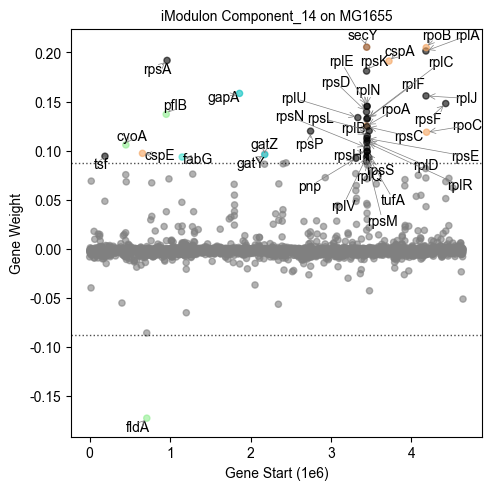

In [29]:
view_iModulon_weights(
    mm,
    species=species_name,
    component=component,
    show_COG=True,
    show_gene_names=True,
    fig_size=(5.3, 5.3),
    font_path = "/usr/share/fonts/truetype/msttcorefonts/Arial.ttf",
    save_path="Paper_Figures/Single_Cell_iM_Translation.svg",
    show_legend=False
)
plt.show()

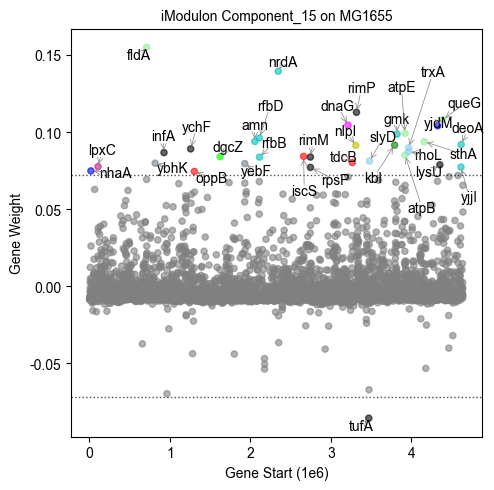

In [33]:
view_iModulon_weights(
    mm,
    species=species_name,
    component="Component_15",
    show_COG=True,
    show_gene_names=True,
    fig_size=(5.3, 5.3),
    font_path = "/usr/share/fonts/truetype/msttcorefonts/Arial.ttf",
    show_legend=False
)
plt.show()